# Assignment 3: Text processing with LSTM in PyTorch

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

In this assignment you will a train an LSTM to generate text. To be able to feed text into (recurrent) neural networks we first have to choose a good representation. There are several options to do so ranging from simple character embeddings to more sophisticated approaches like [word embeddings](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) or [token embeddings](https://medium.com/@_init_/why-bert-has-3-embedding-layers-and-their-implementation-details-9c261108e28a). We will use a character embedding in this assignment. 

Character embeddings work as follows. First we define an alphabet, a set of characters that we want to be able to represent. To feed a character into our network we use a one-hot vector. The dimension of this vector is equal to the size of our alphabet and the "hot" position indicates the character we want to represent. While this is logically a decent representation (all characters have the same norm, are orthogonal to one another, etc.) it is inefficient in terms of memory because we have to store a lot of zeros. In the first layer of our network we will multiply our one-hot vector with a weight matrix, i.e. we compute the preactivation by a matrix-vector product of the form $We_i$, where $e_i$ is the $i$-th canonical basis vector. This operation corresponds to selecting the $i$-th column of $W$. So an efficient implementation is to perform a simple lookup operation in $W$. This is how embedding layers work also for word or token embeddings. They are learnable lookup tables. 

## Exercise 1: Encoding characters

Write a class `Encoder` that implements the methods `__init__` and `__call__`. The method `__init__` takes a string as argument that serves as alphabet. The method `__call__` takes one argument. If it is a string then it should return a sequence of integers as `torch.Tensor` of shape  representing the input string. Each integer should represent a character of the alphabet. The alphabet consists of the characters matched by the regex `[a-z0-9 .!?]`. If the input text contains characters that are not in the alphabet, then `__call__` should either remove them or map them to a corresponding character that belongs to the alphabet. If the argument is a `torch.Tensor`, then the method should return a string representation of the input, i.e. it should function as decoder. 

In [1]:
import re
import torch

########## YOUR SOLUTION HERE ##########

class Encoder:
    
    def __init__(self,alphabet_string:str):
        self.alphabet_list=list(set(alphabet_string.lower()))
        self.alphabet_list.sort()
        pattern = re.compile(fr"[a-z0-9 .!?]")
        
        self.invalid_chars = [_ for _ in self.alphabet_list if not pattern.match(_)] #set of invalid characters
        self.alphabet_list = [_ for _ in self.alphabet_list if pattern.match(_)] #set of valid 
        
        self.alphabet_size = len(self.alphabet_list)
     
        self.alphabet = {char:char_idx for char_idx,char in enumerate(self.alphabet_list)}
    
    def alphabet_size(self):
        return len([_ for _ in self.alphabet_list if pattern.match(_)])
    
    def __call__(self,arg):
        if type(arg)==torch.Tensor:
            return ''.join([self.alphabet_list[int(_.item())] for _ in torch.squeeze(arg)])
        elif type(arg)==str:
            return torch.Tensor([self.alphabet[_] for _ in arg if _ not in self.invalid_chars ]).int()

        
encoder = Encoder("abcdefghijklmnopqrstuvwxyz0123456789.!?'$% ")
tensor_ = encoder("stringt'en'sor")
string_tensor = encoder(encoder("stringt'en'sor"))

print(tensor_)
print(string_tensor)
print(encoder.alphabet_size)

tensor([32, 33, 31, 22, 27, 20, 33, 18, 27, 32, 28, 31], dtype=torch.int32)
stringtensor
40


## Exercise 2: Pytorch Dataset

Write a class `TextDataset` that derives from `torch.utlis.data.Dataset`. It should wrap a text file and utilize it for training with pytorch. Implement the methods `__init__`, `__len__`, `__getitem__`. The method `__init__` should take a path to a text file as string and an integer `l` specifying the length of one sample sequence. The method `__len__` takes no arguments and should return the size of the dataset, i.e. the number of sample sequences in the dataset. The method `__getitem__` should take an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`. The input file can be viewed as one long sequence. The first sample sequence consists of the characters at positions `0..l-1` in the input file. The second sequence consists of the characters at positions `l..2*l-1` and so on. That is, the samples of our dataset are non-overlapping sequences. The last incomplete sequence may be dropped. 

In [2]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

########## YOUR SOLUTION HERE ##########

class TextDataset(torch.utils.data.Dataset):
    
    def __init__(self,file_path:str,l:int):
        
        self.l = l
        
        with open(file_path, encoding="utf8") as text_file:#get file from filepath
            self.raw_data = text_file.read().lower()
        #read file
        
        self.raw_data = self.raw_data.replace("\n"," ").replace("\r"," ")
        #linebreaks create whitespaces
        
        self.encoder = Encoder(self.raw_data)
        self.encoded_data = self.encoder(self.raw_data)
        #create and apply encoder
        
        self.encoded_data = torch.narrow(self.encoded_data,0,0,self.encoded_data.shape[0]-(self.encoded_data.shape[0]%l))
        #last incomplete sequence is dropped
        
        self.sequences = torch.reshape(self.encoded_data,(np.floor(self.encoded_data.shape[0]/self.l).astype(int),l))
        #break data into sequences
    
    def __len__(self):
        return len(self.sequences) #or something
    
    def __getitem__(self,sequence_index):
        """
        call __getitem__ like:
        TextDataset[get_argument]
        """
        return self.sequences[sequence_index]

trump_dataset = TextDataset(r"trump\trump_train.txt",l=256)
print(trump_dataset.encoder.alphabet_list)
print(len(trump_dataset)) #__len__ method
print(trump_dataset.encoder(trump_dataset[668]))

print(trump_dataset[123:142].shape)


[' ', '!', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
3319
things and the husbands one of the great abusers of the world? give me a break. give me a break.       give me a break. so the last person she wants to run against is me.   now heres the story. look heres the story. its very simple. so i announced  and i w
torch.Size([19, 256])


## Exercise 3: The Model

Write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. It should consist of a `torch.nn.Embedding` layer that maps the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet. Implement the methods `__init__` that sets up the module and `forward` that takes an input sequence and returns the logits (i.e. no activation function on the output layer) of the model prediction at every time step. 

In [3]:
import torch.nn as nn
import torch.nn.functional as F

########## YOUR SOLUTION HERE ##########

class NextCharLSTM(torch.nn.Module):

    def __init__(self,alphabet_size:int,embedding_dim:int,hidden_dim:int):
        
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=alphabet_size,embedding_dim=embedding_dim)
        """
        from the docs:
        num_embeddings (int) – size of the dictionary of embeddings
        embedding_dim (int) – the size of each embedding vector
        --> embedding dim is given as input
        """
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=hidden_dim,num_layers=1,batch_first=True) #just one hidden layer is default
        
        self.linear = nn.Linear(in_features=hidden_dim,out_features=alphabet_size)
        
        
    
    def forward(self,input_sequence):
        embedded_sequence=self.embedding(input_sequence)

        lstm_out,hn= self.lstm(embedded_sequence)
        #<-- activation function here?
        logits = self.linear(lstm_out)
                
        return logits
        

model = NextCharLSTM(alphabet_size = trump_dataset.encoder.alphabet_size,
                            embedding_dim = trump_dataset.encoder.alphabet_size,
                            hidden_dim = 25 #arbitrary
                           )
print(trump_dataset[786].shape)
out = model.forward(trump_dataset[786:800])
print(out.shape)

torch.Size([256])
torch.Size([14, 256, 40])


## Exercise 4: Training/Validation Epoch

Write a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function should validate the model. Otherwise it should train the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function should perform one epoch of training/validation and return the loss values of each mini batch as a numpy array. Use the cross-entropy loss function for both training and validation. 

In [4]:
from torch.utils.data import DataLoader
import numpy as np

########## YOUR SOLUTION HERE ##########

def get_input_and_label(batch):
    x = batch[:,:-1]
    y = batch[:,1:]
    return x,y

def epoch(dataloader:DataLoader,model_:NextCharLSTM,optimizer:torch.optim.Optimizer=None):
    
    loss_seq = []
    loss_fn = nn.CrossEntropyLoss()
    
    if optimizer is None:
        for batch_idx,batch in enumerate(dataloader):
        
            x_batch,y_batch =get_input_and_label(batch)

            pred = model_.forward(x_batch)        
            loss = loss_fn(pred.swapaxes(2,1),y_batch.long())

            loss_seq.append(loss.item())

            return np.average(loss_seq)
    
    for batch_idx,batch in enumerate(dataloader):
        progress_percent = np.floor((batch_idx/len(dataloader))*100).astype(int)
        if progress_percent%10==0:
            print(f"\tProgress: {progress_percent}%")
        
        x_batch,y_batch =get_input_and_label(batch)

        optimizer.zero_grad()
        pred = model_.forward(x_batch)
        
        loss = loss_fn(pred.swapaxes(2,1),y_batch.long())
        loss.backward()
        
        optimizer.step()
        
        loss_seq.append(loss.item())
        
        
    return np.array(loss_seq)


## Exercise 5: Model Selection

Usually, we would now train and validate our model with different hyperparameters to see which setting performs best. However, this pretty expensive in terms of compute so we will provide you with a setting that should work quite well. Train your model for 30 epochs using `torch.optim.Adam`. Validate your model after every epoch and persist the model that performs best on the validation set using `torch.save`. Visualize and discuss the training and validation progress. 

In [31]:
import matplotlib.pyplot as plt

sequence_length = 100
batch_size = 256
embedding_dim = 8
hidden_dim = 512
learning_rate = 1e-3
num_epochs = 30

########## YOUR SOLUTION HERE ##########


train_data = TextDataset(r"trump\trump_train.txt",l=100)
valid_data = TextDataset(r"trump\trump_val.txt",l=100)


model = NextCharLSTM(alphabet_size = train_data.encoder.alphabet_size,
                            embedding_dim = embedding_dim,
                            hidden_dim = hidden_dim
                           )


dataloader = DataLoader(train_data,batch_size=256,shuffle=True)
val_dataloader = DataLoader(valid_data,batch_size=256)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

loss_array,val_array = np.array([]),np.array([])

try:
    model.load_state_dict(torch.load("best_model.pt"))
    best_model_performance = np.average(epoch(val_dataloader,model)) #initial validation
except Exception as ex:
    best_model_performance = 10 #a large loss
    print("Loading Model failed: ",str(ex))

if False:
    for _ in range(num_epochs):
        print(f"Epoch number {_+1} of {num_epochs}")
        loss_array = np.append(loss_array,np.average(epoch(dataloader,model,optimizer)))
        val_array = np.append(val_array,np.average(epoch(val_dataloader,model)))
        epoch_performance = np.average(epoch(val_dataloader,model))
        print(f"Validation Accuracy: {epoch_performance}")
        
        if np.average(epoch(val_dataloader,model)) < best_model_performance:
            print(f"New best model at {epoch_performance} loss")
            torch.save(model.state_dict(), "best_model.pt")
            best_model_performance = epoch_performance
        else:
            print("Model performs worse than best model")



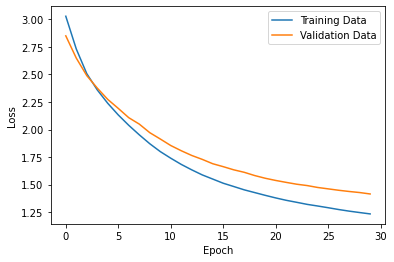

In [21]:
plt.plot(loss_array.flatten(),label="Training Data")
plt.plot(val_array.flatten(),label="Validation Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The Validation accuracy increases until approx. the 50th epoch and decreases thereafter. Accuracy over the training data however increases until -- and likely beyond -- the 100th epoch. This type of learning curve is a clear sign of overfitting.

It can be concluded that the model performs best when trained between 50 and 80 epochs.

## Exercise 6: Top-$k$ Accuracy

Write a function `topk_accuracy` that takes a list of integers $k$, a model, and a data loader and returns the top-$k$ accuracy of the model on the given data set for each $k$. A sample is considered to be classified correctly if the true label appears in the top-$k$ classes predicted by the model. Then load the best model from the previous exercise using `torch.load` and plot its top-$k$ accuracy as a function of $k$ for all possible values of $k$. Discuss the results. 

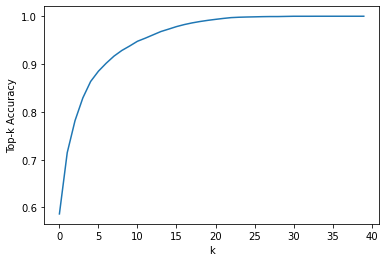

In [22]:
########## YOUR SOLUTION HERE ##########

def topk_accuracy(k_list:list,model:NextCharLSTM,dataloader:DataLoader):
    
    topk_accuracy_dict = {k:[] for k in k_list}
    for batch_idx,batch in enumerate(dataloader):

        x_batch,y_batch =get_input_and_label(batch)

        pred = model.forward(x_batch)        
        
        for k,k_accuracies in topk_accuracy_dict.items():
            pred_topk = torch.topk(pred,k,dim=2,sorted=True)
            topk_acc = torch.any(pred_topk.indices == y_batch.unsqueeze(2),dim=2)
            topk_acc_sequence_mean = torch.mean(topk_acc.type(torch.float),dim=1) #mean accuracies of the individual sequences
            topk_acc_batch_mean = torch.mean(topk_acc_sequence_mean) #mean over the whole batch
            
            k_accuracies.append(topk_acc_batch_mean)
        
    for k,k_accuracies in topk_accuracy_dict.items():
        topk_accuracy_dict[k]=np.mean(topk_accuracy_dict[k]) #mean over all batches
        
    return topk_accuracy_dict

loaded_model = NextCharLSTM(alphabet_size = train_data.encoder.alphabet_size,
                            embedding_dim = embedding_dim,
                            hidden_dim = hidden_dim
                           )
loaded_model.load_state_dict(torch.load("best_model.pt"))
loaded_model.eval()

topk_out = topk_accuracy(list(range(1,41)),loaded_model,val_dataloader)

plt.plot(topk_out.values())
plt.xlabel("k")
plt.ylabel("Top-k Accuracy")
plt.show()

The Top-k Accuracy of the best model increases with k. This makes intuitive sense. If k is equal to one, the Top-k accuracy is the percentage of correct first guesses over all guesses. If k is equal to the size of the alphabet, every guess is correct because the correct character is always in the top-k guesses.

The graph also shows that the correct letter is likely within the top-10 letters predicted by the model.

## Exercise 7: Deterministic Text Generation

In this exercise we utilize the trained network to generate novel text. To do this, take some seed text, which can be chosen by the user, and feed it to the network. Subsequently, extrapolate new text by always appending the top-1 character according to the model prediction to the input sequence. Discuss the quality of your model as a text generator. 

In [23]:
########## YOUR SOLUTION HERE ##########
def determ_pred(self,input_str:str,pred_len:int):
    prediction = encoder(input_str)[None,:]
    for _ in range(pred_len):
        iter_prediction = self.forward(prediction)
        iter_prediction_idx = torch.max(iter_prediction,dim=2).indices
        
        prediction = torch.cat((prediction,iter_prediction_idx[:,-1].unsqueeze(0)),dim=1)
    
    return prediction

NextCharLSTM.determ_pred = determ_pred

output = model.determ_pred("last year they ",200)
print(encoder(output))

last year they said the trade deals and they dont want to be a lot of the greatest people that were going to be a lot of the greatest people that were going to be a lot of the greatest people that were going to be a


The deterministic text generation is very accurate in term of spelling. Unfortunately all deterministically generated texts fall into an infinite loop. When retraining the model, the loop usually changes but remains the same over all input sequences. 
Depending on the length and content of the input sequence it can take more time for the model to fall into the loop though it always does.

## Exercise 8: Probabilistic Text Generation

Utilize your trained model as text generator as in the previous exercise but with one difference. Instead of always choosing the top-1 character make a probabilistic choice. The network prediction constitutes a probability distribution over the alphabet. Choose the next character by sampling from this distribution. Compare the results to those of the previous exercise and discuss the observed differences. 

In [26]:
from torch.distributions import Categorical

########## YOUR SOLUTION HERE ##########


def prob_pred(self,input_str:str,pred_len:int):
    prediction = encoder(input_str)[None,:]
    for _ in range(pred_len):
        iter_prediction = self.forward(prediction)
        prob_distribution = Categorical(logits=iter_prediction[:,-1].unsqueeze(0))
        sample = prob_distribution.sample()[0][:1]
                
        prediction = torch.cat((prediction,sample.unsqueeze(0)),dim=1)
    
    return prediction

NextCharLSTM.prob_pred=prob_pred

output = model.prob_pred("joe biden ",200)
print(encoder(output))

joe biden sid. we are got to pot every our sometion. you know if younla ktory china is president badkas everybody everybody everything oe with the canter of the discords the enorom. ire wone dont gay. thats hap


The probabalistic model lacks in terms of spelling compared to the deterministic one. It does not although fall into infinite loops. This makes the generated text much more pleasant to read. Unfortunately even the probabalistic model does not have any semantic content. Probabalistically generated texts are usually comically meaningless. The rare occasions in which a topic persists over multiple sentences in the generated text are likely generated by chance.

## Exercise 9: Visualize Neurons

Visualize the value of the 512 neurons while the trained model processes some user-defined text. Take a look at the last figure of [this blog](https://openai.com/blog/unsupervised-sentiment-neuron/) (which is also a good read) to get an idea of how to do the visualization. You can install and use the package `colorama` for that. Can you figure out certain repsonsibilities of certain neurons?

In [1]:
# provides readable names for ANSI escape sequences
from colorama import Fore, Back, Style

########## YOUR SOLUTION HERE ##########

def forward_hidden(self,input_sequence):
    embedded_sequence=self.embedding(input_sequence)

    lstm_out,hn= self.lstm(embedded_sequence)
    #<-- activation function here?
    logits = self.linear(lstm_out)

    return logits, hn[0]

def get_all_hidden(self,input_str):
    input_seq = encoder(input_str)[None,:]
    print(input_seq.shape)
    prediction,hidden = self.forward_hidden(input_seq[None,:,0])
    
    for _ in range(1,input_seq.shape[-1]):
        
        iter_prediction,iter_hidden = self.forward_hidden(input_seq[:,:_])
        hidden = torch.cat((hidden,iter_hidden),dim=1)
                    
    return hidden


NextCharLSTM.forward_hidden = forward_hidden
NextCharLSTM.get_all_hidden = get_all_hidden

input_string = encoder(valid_data[20])

model.load_state_dict(torch.load("best_model.pt"))

all_hidden = model.get_all_hidden(input_string)

for _ in range(512):
    neuron_idx = _ #any given neuron
    out_string = ""
    for char_idx,char in enumerate(input_string):
        if all_hidden[0,char_idx,neuron_idx] > 0:
            #print(f"{char} green")
            out_string += (Back.GREEN +char)

        elif all_hidden[0,char_idx,neuron_idx] < 0:
            #print(f"{char} yellow")
            out_string += (Back.YELLOW +char)

        print(Back.WHITE+f"neuron {neuron_idx}: ",out_string)



NameError: name 'NextCharLSTM' is not defined

For the life of me I cannot figure out why colorama does not work. It works in my console.
This is the way the docs want me to do it.
I do not call colorama.init() because its jupyter notebook.

It works in google colab though where i got the results from:

As for the neurons responsibilities I did not find any noticeable patterns. It could be that some neurons activate at the end of sentences for example. Such behaviour is not to be found in my net however. 

The neurons do although show very distinct and consistent behaviour. Eg some change activation rapidly other almost never.

## Bonus Exercise (3 Points):

Adapt your code from the previous exercises such that the model runs in the many-to-one setting, i.e., it should read `l-1` characters of a sample sequence and predict the `l`-th character. Train/validate the model in the many-to-one setting and compare it to the many-to-many setting in terms of top-$k$ accuracy on the validation set and probabilistic text generation. Visualize your results. What are the pros and cons? 

In [11]:
########## YOUR SOLUTION HERE ##########

## Feeding the Hitchikers Guide to the Galaxy by Douglas Adams into it

In [12]:
train_data = TextDataset(r"dontpanic\dontpanic_train.txt",l=100)
valid_data = TextDataset(r"dontpanic\dontpanic_validate.txt",l=100)

In [18]:
dontpanic_num_epochs = 100

dontpanic_model = NextCharLSTM(alphabet_size = train_data.encoder.alphabet_size,
                            embedding_dim = embedding_dim,
                            hidden_dim = hidden_dim
                           )

dontpanic_dataloader = DataLoader(train_data,batch_size=256,shuffle=True)
dontpanic_val_dataloader = DataLoader(valid_data,batch_size=256)
dontpanic_optimizer = torch.optim.Adam(dontpanic_model.parameters(),lr=learning_rate)


try:
    dontpanic_model.load_state_dict(torch.load("dontpanic_best_model.pt"))
    dontpanic_best_model_performance = np.average(epoch(dontpanic_val_dataloader,dontpanic_model)) #initial validation
    print(f"Loaded model at {dontpanic_best_model_performance} loss")
except Exception as ex:
    dontpanic_best_model_performance = 10 #a large loss 
    print("Loading Model failed: ",str(ex))

dontpanic_loss_array,dontpanic_val_array = np.array([]),np.array([])

if False:
    for _ in range(dontpanic_num_epochs):
        print(f"Epoch number {_+1} of {dontpanic_num_epochs}")
        dontpanic_loss_array = np.append(dontpanic_loss_array,np.average(epoch(dontpanic_dataloader,dontpanic_model,dontpanic_optimizer)))
        dontpanic_val_array = np.append(dontpanic_val_array,np.average(epoch(dontpanic_val_dataloader,dontpanic_model)))
        epoch_performance = np.average(epoch(dontpanic_val_dataloader,dontpanic_model))
        print(f"Validation Accuracy: {epoch_performance}")
        print(f"Training Accuracy: {dontpanic_loss_array[-1]}")
        if np.average(epoch(dontpanic_val_dataloader,dontpanic_model)) < dontpanic_best_model_performance:
            print("New best model")
            torch.save(dontpanic_model.state_dict(), "dontpanic_best_model.pt")
            dontpanic_best_model_performance = epoch_performance
        else:
            print("Model performs worse than best model")

Loading Model failed:  [Errno 2] No such file or directory: 'dontpanic_best_model.pt'
Epoch number 1 of 100
	Progress: 0%
	Progress: 20%
	Progress: 50%
	Progress: 70%
Validation Accuracy: 2.8729984760284424
Training Accuracy: 3.052024806247038
New best model
Epoch number 2 of 100
	Progress: 0%
	Progress: 20%
	Progress: 50%
	Progress: 70%
Validation Accuracy: 2.670996904373169
Training Accuracy: 2.76302609724157
New best model
Epoch number 3 of 100
	Progress: 0%
	Progress: 20%
	Progress: 50%
	Progress: 70%
Validation Accuracy: 2.4925286769866943
Training Accuracy: 2.534297999213724
New best model
Epoch number 4 of 100
	Progress: 0%
	Progress: 20%
	Progress: 50%
	Progress: 70%
Validation Accuracy: 2.3703441619873047
Training Accuracy: 2.3585342729792877
New best model
Epoch number 5 of 100
	Progress: 0%
	Progress: 20%
	Progress: 50%
	Progress: 70%
Validation Accuracy: 2.2609364986419678
Training Accuracy: 2.223292182473575
New best model
Epoch number 6 of 100
	Progress: 0%
	Progress: 20%

KeyboardInterrupt: 

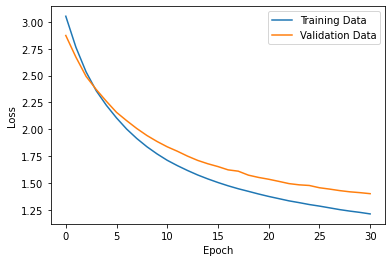

In [19]:
plt.plot(dontpanic_loss_array.flatten(),label="Training Data")
plt.plot(dontpanic_val_array.flatten(),label="Validation Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
dontpanic_model.load_state_dict(torch.load("dontpanic_best_model.pt"))

dontpanic_output = dontpanic_model.determ_pred("arthur was ",200)
print(encoder(dontpanic_output))

dontpanic_output = dontpanic_model.prob_pred("arthur was ",200)
print(encoder(dontpanic_output))



arthur was a great company that was a tough the people that are so incredible country and they said what i dont want to be a lot of the polls and they said what i dont want to be a lot of the polls and they said
arthur was geacing buch. bevernobs namessbad could belice its suve more. so zourd maky trump for the word naypy. and i think i said no i ain theyre toing never great things and jnbder bus ast that person ive get
